## Importar paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Carga de datos 

#### Exploración información base

De la definición del reto extraemos el significado de cada columna y también apuntamos **pistas**/**indicaciones** necesarias para la correcta realización del reto que se nos ha propuesto

> "las OF (Orden de Fabiración) o lotes que no estén en esta tabla no se deben tener en cuenta"


In [2]:
df_info_general = pd.read_excel('raw_data/OF 123456.xlsx', parse_dates=['Fecha de inicio real', 'Fecha de fin real'], engine='openpyxl')
df_info_general.head(5)

,Orden,Número material,Texto breve material,Lote,Fecha de inicio real,Fecha de fin real,Cantidad entregada,Unidad de medida
0,200178572,123456,MATERIAL DESCRITION,23/019,2023-04-24,2023-04-24,13.8,L
1,200179217,123456,MATERIAL DESCRITION,23/020,2023-04-24,2023-04-24,13.6,L
2,200181620,123456,MATERIAL DESCRITION,23/021,2023-04-25,2023-04-25,13.5,L
3,200182428,123456,MATERIAL DESCRITION,23/022,2023-04-25,2023-04-25,13.8,L
4,200182429,123456,MATERIAL DESCRITION,23/023,2023-05-02,2023-05-02,13.7,L


Comprobamos que las fechas y resto de tipo de datos se han cargado correctamente

In [3]:
df_info_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Orden                 205 non-null    int64         
 1   Número material       205 non-null    int64         
 2   Texto breve material  205 non-null    object        
 3   Lote                  205 non-null    object        
 4   Fecha de inicio real  205 non-null    datetime64[ns]
 5   Fecha de fin real     205 non-null    datetime64[ns]
 6   Cantidad entregada    205 non-null    float64       
 7   Unidad de medida      205 non-null    object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 12.9+ KB


In [4]:
df_info_general['Número material'].nunique()

1

Efectivamente esta tabla solamente pertenece a un mismo material (123456)

In [5]:
ordenes = df_info_general['Orden'].unique()
lotes = df_info_general['Lote'].unique()

print(f"Total ordenes únicas {len(ordenes)}")
print(f"Total lotes únicos {len(lotes)}")

Total ordenes únicas 205
Total lotes únicos 205


Parece ser que hay una relación 1-1 entre las ordenes y lotes

La única columna que interesaría saber algun dato estadístico es el de la cantidad entregada de material, dado que el resto son valores categóricos o de por si no tienen gran significado y se podría prescindir de ellas

In [6]:
df_info_general['Cantidad entregada'].describe()

count    205.000000
mean      13.538829
std        1.364665
min        0.000000
25%       13.600000
50%       13.700000
75%       13.780000
max       14.000000
Name: Cantidad entregada, dtype: float64

La cantidad entregada parece ser muy estable, con ello queremos decir que suele rondar los mismos valores por cada orden/lote. La variación entre lotes es mínima, lo cual ya nos da indicios de que habrá que fijarse con lupa en décimas/centésimas para saber si la producción es óptima

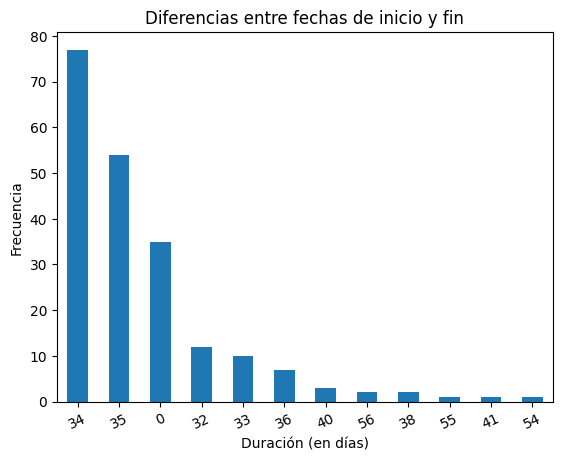

In [7]:
df_info_general['diferencia_fechas'] = (df_info_general['Fecha de fin real'] - df_info_general['Fecha de inicio real']).dt.days 

df_info_general['diferencia_fechas'].value_counts().plot(kind="bar")

plt.title("Diferencias entre fechas de inicio y fin")
plt.xlabel("Duración (en días)")
plt.ylabel("Frecuencia")
plt.xticks(rotation = 25)
plt.show()

In [8]:
df_info_general['diferencia_fechas'].describe()

count    205.000000
mean      28.936585
std       13.529593
min        0.000000
25%       33.000000
50%       34.000000
75%       35.000000
max       56.000000
Name: diferencia_fechas, dtype: float64

Dado que las fechas de inicio y fin de por si no nos dicen nada, se nos ha ocurrido ver el tiempo que pasa (en días) entre el inicio y fin de cada orden/lote. Viendo la gráfica y los datos estadísticos, nos podemos hacer a la idea de cuanto suele durar el proceso de cultivo. Por otro lado podemos identificar más adelante (con más variables) alguna patrón que justifique estos tiempos, dado que es notoria la diferencia tanto en la distribución de la duración del proceso completo. Lo que está claro es que suele conllevar más de un mes y "poco" para conseguir un "buen" resultado

#### Exploración diferentes fases producción

Toda los datos se encuentras en el mismo archivos, pero en hojas de Excel diferentes por lo que las cachearemos en *dataframes* diferentes para más comodidad

#####  Preinóculo

Esta hoja tiene como algo "especial" la cabecera, ya que se conforma por dos líneas. La cargaremos y renombraremos para que sea más legible

In [123]:
df_preinoculo = pd.read_excel('raw_data/Fases producción.xlsx', sheet_name='Preinóculo', header=[0, 1], engine='openpyxl')
df_preinoculo.head(5)

Unnamed: 0_level_0  Unnamed: 1_level_0  Unnamed: 2_level_0      pH          \
                LOTE   Fecha/hora inicio      Fecha/hora fin línea 1 línea 2   
0              23023 2023-03-26 05:00:00 2023-03-27 07:21:00   5.496   5.504   
1              23024 2023-03-26 05:00:00 2023-03-27 07:21:00   5.496   5.504   
2              23025 2023-03-17 06:00:00 2023-03-28 07:42:00   5.480   5.520   
3              23026 2023-03-17 06:00:00 2023-03-28 07:42:00   5.480   5.520   
4              23027 2023-04-02 05:00:00 2023-04-03 13:30:00   5.384   5.440   

          Turbidez                 Línea utilizada                  
  línea 3  línea 1 línea 2 línea 3         línea 1 línea 2 línea 3  
0    5.52    28.32   27.92      32               1       1       0  
1    5.52    28.32   27.92      32               1       1       0  
2    5.52    26.56   27.52    26.4               1       1       0  
3    5.52    26.56   27.52    26.4               1       1       0  
4     5.4    33.84   30.56   32.48               1       0       1

In [124]:
df_preinoculo.shape

(165, 12)

Reducimos/simplificamos las columnas para que sea más fácil leer y acceder a ellas

In [125]:
new_cols = [l2 if 'Unnamed' in l1 else f"{l1} {l2}" for l1, l2 in df_preinoculo.columns.to_list()]
df_preinoculo.columns = new_cols
df_preinoculo.head(5)

,LOTE,Fecha/hora inicio,Fecha/hora fin,pH línea 1,pH línea 2,pH línea 3,Turbidez línea 1,Turbidez línea 2,Turbidez línea 3,Línea utilizada línea 1,Línea utilizada línea 2,Línea utilizada línea 3
0,23023,2023-03-26 05:00:00,2023-03-27 07:21:00,5.496,5.504,5.52,28.32,27.92,32,1,1,0
1,23024,2023-03-26 05:00:00,2023-03-27 07:21:00,5.496,5.504,5.52,28.32,27.92,32,1,1,0
2,23025,2023-03-17 06:00:00,2023-03-28 07:42:00,5.480,5.520,5.52,26.56,27.52,26.4,1,1,0
3,23026,2023-03-17 06:00:00,2023-03-28 07:42:00,5.480,5.520,5.52,26.56,27.52,26.4,1,1,0
4,23027,2023-04-02 05:00:00,2023-04-03 13:30:00,5.384,5.440,5.4,33.84,30.56,32.48,1,0,1


Si echamos la vista atras, la columna de `LOTE` no tiene los mismos valores con barras como en la tabla anterior, sino mas bien es un número entero. 
Para poder fijarnos exclusivamente en los lotes que nos interesa tenemos que transformar su formato. 
**NOTA** Esto es importante para la limpieza y mezcla de tablas posterior, ahora tan solo nos ayudara a ser mas concisos con la exploración

In [126]:
LOTES = [int(l.replace('/', '').replace('P', '')) for l in lotes]

Se reduce ligeramente el conjunto de datos con este "cruce" de tablas

In [127]:
df_preinoculo = df_preinoculo[df_preinoculo['LOTE'].isin(LOTES)]
df_preinoculo.shape

(153, 12)

Viendo la información resumida de los datos cargados, vemos que en algunas columnas hay valores perdidos. De ahí puede ser que en algunas variables de la línea `3` no se haya inferido correctamente el tipo de datos

In [128]:
df_preinoculo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 0 to 163
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   LOTE                     153 non-null    object        
 1   Fecha/hora inicio        153 non-null    datetime64[ns]
 2   Fecha/hora fin           153 non-null    datetime64[ns]
 3   pH línea 1               151 non-null    float64       
 4   pH línea 2               140 non-null    float64       
 5   pH línea 3               128 non-null    object        
 6   Turbidez línea 1         151 non-null    float64       
 7   Turbidez línea 2         140 non-null    float64       
 8   Turbidez línea 3         128 non-null    object        
 9   Línea utilizada línea 1  153 non-null    int64         
 10  Línea utilizada línea 2  153 non-null    int64         
 11  Línea utilizada línea 3  153 non-null    int64         
dtypes: datetime64[ns](2), float64(4), int64(3

Al ser un conjunto de datos pequeño, los número de registros perdidos son un tanto significativos (sobretodo para las variables de `ph` y `turbidez` de la línea `3`). Para simplificar el proceso de exploración, imputaremos los valores por la media basandonos en que a simple vista no hay gran desviación en dichas variables.

In [129]:
df_preinoculo.isna().sum()/df_preinoculo.shape[0] * 100

LOTE                        0.000000
Fecha/hora inicio           0.000000
Fecha/hora fin              0.000000
pH línea 1                  1.307190
pH línea 2                  8.496732
pH línea 3                 16.339869
Turbidez línea 1            1.307190
Turbidez línea 2            8.496732
Turbidez línea 3           16.339869
Línea utilizada línea 1     0.000000
Línea utilizada línea 2     0.000000
Línea utilizada línea 3     0.000000
dtype: float64

In [130]:
def impute_mean_values(df, columns):
    for c in columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[c] = df_preinoculo[c].fillna(df[c].mean())
    return df 

cols_to_fill = df_preinoculo.columns[df_preinoculo.isna().any()].to_list()
print(f"Columnas donde imputar valores {cols_to_fill}")
df_preinoculo = impute_mean_values(df_preinoculo, cols_to_fill)

Columnas donde imputar valores ['pH línea 1', 'pH línea 2', 'pH línea 3', 'Turbidez línea 1', 'Turbidez línea 2', 'Turbidez línea 3']


In [131]:
df_preinoculo.dtypes

LOTE                               object
Fecha/hora inicio          datetime64[ns]
Fecha/hora fin             datetime64[ns]
pH línea 1                        float64
pH línea 2                        float64
pH línea 3                        float64
Turbidez línea 1                  float64
Turbidez línea 2                  float64
Turbidez línea 3                  float64
Línea utilizada línea 1             int64
Línea utilizada línea 2             int64
Línea utilizada línea 3             int64
dtype: object

In [132]:
df_preinoculo.describe(include=[float])

,pH línea 1,pH línea 2,pH línea 3,Turbidez línea 1,Turbidez línea 2,Turbidez línea 3
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,5.468026,5.462800,5.484618,31.144901,29.990857,29.385366
std,0.108896,0.061538,0.118673,5.366878,3.797285,4.122067
min,5.232000,5.336000,5.208000,20.960000,22.480000,17.360000
25%,5.400000,5.424000,5.416000,27.280000,27.600000,26.960000
50%,5.464000,5.462800,5.484618,30.560000,29.990857,29.385366
75%,5.512000,5.504000,5.512000,33.840000,32.080000,30.880000
max,6.280000,5.624000,6.112000,50.640000,49.440000,41.280000


Vemos claramente que el `pH` suele oscilar entre `5` y `6`, la diferencia entre lotes la determinarán los decimales, por lo cual sería recomendable utilizar como mínimo tres decimales.

De la descripción del reto sabemos lo siguiente 

> "se seleccionan los dos frascos con el pH más bajo... El tercer frasco se desecha"

En cuanto a la `turbidez` no queda claro la unidad de medida, por lo que debemos ser nosotros los que interpretemos los valores. 
Entenderemos por una mayor turbidez (menor transparencia del material líquido) valores altos, y menor turbidez con valores bajos. El problema de esto es que nos contamos con una escala para saber cuales son los posibles máximos que se pueden alcanzar.

Al diferencia del `pH`, la `turbidez` si que presenta una mayor oscilación entre las muestras. 

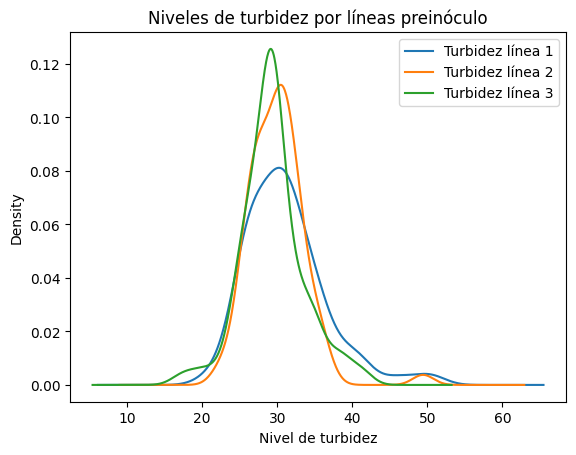

In [133]:
df_preinoculo[['Turbidez línea 1', 'Turbidez línea 2', 'Turbidez línea 3']].plot(kind='density')

plt.title("Niveles de turbidez por líneas preinóculo")
plt.xlabel("Nivel de turbidez")
plt.show()

Parece que los valores tienden a seguir una distribución "normal" como eje el valor `30` para todas las líneas de preinóculo.
Veamos si el `pH` tiene alguna relación con los valores de turbidez

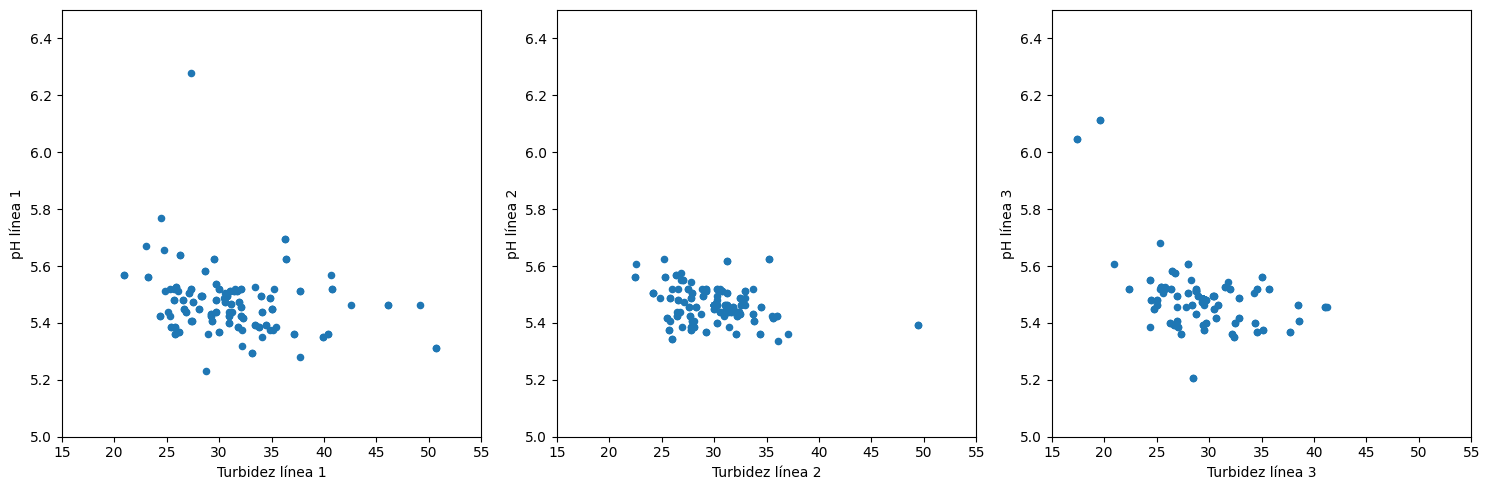

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    df_preinoculo.plot(kind='scatter', x=f'Turbidez línea {i+1}', y=f'pH línea {i+1}', ax=axes[i])
    # Misma escala 
    axes[i].set_xlim(15, 55) # min y max Turbidez
    axes[i].set_ylim(5, 6.5) # min y max Ph

plt.tight_layout()

La relación es casi constante dado que la nube de puntos se concentra en las mismas zonas para las tres líneas. Queda claro que valores de Ph ideales se mantienen entre `5.4` y `5.6`. En cuanto a la turbidez la línea 2 parece ser la que menos desviación tiene entre las muestras, dado que tanto la línea 1 y 3 presentan nubes más dispersas junto con ciertos *outliers*

In [135]:
lineas = df_preinoculo.select_dtypes(include='int64')
lineas.sum() # Líneas más utilizadas para siguiente fase

Línea utilizada línea 1    125
Línea utilizada línea 2    108
Línea utilizada línea 3     55
dtype: int64

In [136]:
lineas.value_counts()

Línea utilizada línea 1  Línea utilizada línea 2  Línea utilizada línea 3
1                        1                        0                          80
                         0                        1                          35
0                        1                        1                          20
1                        0                        0                          10
0                        1                        0                           8
Name: count, dtype: int64

La combinación de las línea 1 y 2 es la más propensa a "pasar de fase".
La línea 1, sin duda es la más utilizada, mientras que la línea 3 la mas desechada

**NOTA**
Por otro lado vemos que hay un total de `18` lotes en los que tan solo se utiliza una de las líneas. Algo que contradice el enunciado del reto

In [142]:
df_preinoculo['duracion_horas'] = (df_preinoculo['Fecha/hora fin'] - df_preinoculo['Fecha/hora inicio']).dt.total_seconds() / 3600

# Tras realizar la operacion aparecen algunos valores negativos -> MUY EXTRAÑO!! INSPECCIONAR LOTES EN OTRAS FASES
df_preinoculo[df_preinoculo['duracion_horas'] < 0 ]

,LOTE,Fecha/hora inicio,Fecha/hora fin,pH línea 1,pH línea 2,pH línea 3,Turbidez línea 1,Turbidez línea 2,Turbidez línea 3,Línea utilizada línea 1,Línea utilizada línea 2,Línea utilizada línea 3,duracion_horas
10,23033,2023-04-23 05:00:00,2023-03-24 13:30:00,5.448,5.456,5.392000,28.08,28.24,29.440000,1,0,1,-711.5
11,23034,2023-04-23 05:00:00,2023-03-24 13:30:00,5.448,5.456,5.392000,28.08,28.24,29.440000,1,0,1,-711.5
12,23035,2023-04-23 05:00:00,2023-03-24 07:30:00,5.520,5.520,5.484618,25.68,26.56,29.385366,1,0,0,-717.5


In [144]:
df_preinoculo[df_preinoculo['duracion_horas'] > 0 ]['duracion_horas'].describe()

count    150.000000
mean      33.268444
std       27.423790
min       25.000000
25%       26.770833
50%       30.750000
75%       31.083333
max      265.700000
Name: duracion_horas, dtype: float64

El 75% de los lotes necesitan de al menos de unas 30 horas para obtener el preinóculo. Ahora bien, la desviación de la duración para realizar esta primera fase es muy grande, tendremos que investigar si hay otras variables que afecten a obtener una línea para ser utilizada.

##### Inóculo

In [23]:
df_inoculo = pd.read_excel('raw_data/Fases producción.xlsx', sheet_name='Inóculo', engine='openpyxl')
df_inoculo.head(5)

,LOTE,ID bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de cultivo,Turbidez inicio cultivo,Turbidez final culttivo,Viabilidad final cultivo
0,23019,13171,NaT,NaT,NaN,NaN,32.80,134400000
1,23020,13171,NaT,NaT,NaN,NaN,32.80,134400000
2,23021,14618,NaT,NaT,NaN,NaN,27.84,115200000
3,23022,14618,NaT,NaT,NaN,NaN,27.84,115200000
4,23023,14618,2023-03-27 07:22:00,2023-03-28 07:29:00,155.2,18.24,31.68,106400000


##### Cultivo final

In [11]:
df_cultivo = pd.read_excel('raw_data/Fases producción.xlsx', sheet_name='Cultivo final', engine='openpyxl')
df_cultivo.head(5)

,LOTE,Orden en el encadenado,LOTE parental,ID Bioreactor,Fecha/hora inicio,Fecha/hora fin,Volumen de inóculo utilizado,Turbidez inicio cultivo,Turbidez fin cultivo,Viabilidad final cultivo,ID Centrífuga,Centrifugación 1 turbidez,Centrifugación 2 turbidez,Producto 1,Producto 2
0,23019,1,NaN,14615,2023-03-21 07:30:00,2023-03-23 06:30:00,82.4,17.28,91.2,184000000,17825,NaN,NaN,1747.920,6.00
1,23020,1,NaN,14616,2023-03-21 07:30:00,2023-03-23 06:30:00,80.4,18.80,91.2,181600000,14246,NaN,NaN,1676.160,6.56
2,23021,1,NaN,13170,2023-03-22 07:30:00,2023-03-24 06:30:00,66.4,16.16,86.4,248000000,17825,NaN,NaN,1928.496,8.08
3,23022,1,NaN,14614,2023-03-22 07:30:00,2023-03-24 06:30:00,85.6,18.48,83.2,229600000,12912,NaN,NaN,1782.800,5.92
4,23023,1,NaN,14615,2023-03-28 07:27:00,2023-03-30 10:00:00,77.6,17.12,74.4,132800000,17825,26.56,20.88,1861.840,2.96


In [25]:
ids_inoculo_biorreactor = [13171, 13172, 14618]
ids_cultivo_biorreactor = [13169, 13170, 14614, 14615, 14616, 14617]

In [27]:
df_biorreactor = pd.read_excel(f'raw_data/Biorreactor {ids_inoculo_biorreactor[0]}.xlsx',
                               sheet_name='Datos', index_col='DateTime', parse_dates=True, engine='openpyxl')
df_biorreactor.head(5)

,13171_FERM0101.Agitation_PV,13171_FERM0101.Air_Sparge_PV,13171_FERM0101.Biocontainer_Pressure_PV,13171_FERM0101.DO_1_PV,13171_FERM0101.DO_2_PV,13171_FERM0101.Gas_Overlay_PV,13171_FERM0101.Load_Cell_Net_PV,13171_FERM0101.pH_1_PV,13171_FERM0101.pH_2_PV,13171_FERM0101.PUMP_1_PV,13171_FERM0101.PUMP_1_TOTAL,13171_FERM0101.PUMP_2_PV,13171_FERM0101.PUMP_2_TOTAL,13171_FERM0101.Single_Use_DO_PV,13171_FERM0101.Single_Use_pH_PV,13171_FERM0101.Temperatura_PV
DateTime,,,,,,,,,,,,,,,,
2023-03-15 00:00:00,0.0,0.0,480.0,0.0,0.0,0.0,-6.640000,1.869104,3.2,0.0,17.773326,0.0,11066.217969,799.991992,800.295996,19.130649
2023-03-15 00:15:00,0.0,0.0,480.0,0.0,0.0,0.0,-6.640000,1.869104,3.2,0.0,17.773326,0.0,11066.217969,799.991992,800.295996,19.117385
2023-03-15 00:30:00,0.0,0.0,480.0,0.0,0.0,0.0,-6.638355,1.869104,3.2,0.0,17.773326,0.0,11066.217969,799.991992,800.295996,19.128038
2023-03-15 00:45:00,0.0,0.0,480.0,0.0,0.0,0.0,-6.640000,1.869104,3.2,0.0,17.773326,0.0,11066.217969,799.991992,800.295996,19.127873
2023-03-15 01:00:00,0.0,0.0,480.0,0.0,0.0,0.0,-6.640000,1.869104,3.2,0.0,17.773326,0.0,11066.217969,799.991992,800.295996,19.080857


In [29]:
df_biorreactor = pd.read_excel(f'raw_data/Biorreactor {ids_cultivo_biorreactor[0]}.xlsx',
                               sheet_name='Datos', index_col='DateTime', parse_dates=True, engine='openpyxl')
df_biorreactor.head(5)

,13169_FERM0101.Agitation_PV,13169_FERM0101.Air_Sparge_PV,13169_FERM0101.Biocontainer_Pressure_PV,13169_FERM0101.DO_1_PV,13169_FERM0101.DO_2_PV,13169_FERM0101.Gas_Overlay_PV,13169_FERM0101.Load_Cell_Net_PV,13169_FERM0101.pH_1_PV,13169_FERM0101.pH_2_PV,13169_FERM0101.PUMP_1_PV,13169_FERM0101.PUMP_1_TOTAL,13169_FERM0101.PUMP_2_PV,13169_FERM0101.PUMP_2_TOTAL,13169_FERM0101.Single_Use_DO_PV,13169_FERM0101.Single_Use_pH_PV,13169_FERM0101.Temperatura_PV
DateTime,,,,,,,,,,,,,,,,
2023-03-15 00:00:00,0.0,0.0,480.0,0.0,NaN,0.0,-20.000000,1.56356,-0.011332,0.0,27.280002,0.0,1486.330176,655.892432,799.623975,18.163524
2023-03-15 00:15:00,0.0,0.0,480.0,0.0,NaN,0.0,-17.335388,1.56356,-0.011332,0.0,27.280002,0.0,1486.330176,655.892432,799.623975,18.102256
2023-03-15 00:30:00,0.0,0.0,480.0,0.0,NaN,0.0,-20.035917,1.56356,-0.011332,0.0,27.280002,0.0,1486.330176,655.892432,799.623975,18.070250
2023-03-15 00:45:00,0.0,0.0,480.0,0.0,NaN,0.0,-20.260454,1.56356,-0.011332,0.0,27.280002,0.0,1486.330176,655.892432,799.623975,18.004430
2023-03-15 01:00:00,0.0,0.0,480.0,0.0,NaN,0.0,-20.399136,1.56356,-0.011332,0.0,27.280002,0.0,1486.330176,655.892432,799.623975,18.020433


In [34]:
df_ipc_inoculo = pd.read_excel('raw_data/Cinéticos IPC.xlsx', sheet_name='Inóculos', engine='openpyxl')
df_ipc_inoculo.head(5)

,Lote,Fecha,Turbidez,Viabilidad
0,23019,2023-03-21 06:30:00,32.80,134400000.0
1,23020,2023-03-21 06:30:00,32.80,134400000.0
2,23021,2023-03-22 06:30:00,27.84,115200000.0
3,23022,2023-03-22 06:30:00,27.84,115200000.0
4,23023,2023-03-27 07:30:00,18.24,10880000.0


In [35]:
df_ipc_cultivo = pd.read_excel('raw_data/Cinéticos IPC.xlsx', sheet_name='Cultivos finales', engine='openpyxl')
df_ipc_cultivo.head(5)

,Lote,Fecha,Turbidez,Viabilidad,Glucosa g/L
0,23019,2023-03-21 07:30:00,17.28,8.333333e+06,1.744
1,23019,2023-03-21 11:00:00,17.28,1.397333e+07,1.968
2,23019,2023-03-21 14:00:00,18.4,1.688000e+07,1.92
3,23019,2023-03-21 18:00:00,19.76,2.474667e+07,1.88
4,23019,2023-03-22 07:00:00,39.12,1.000000e+08,1.568


In [36]:
df_ipc_centrifuga = pd.read_excel('raw_data/Cinéticos IPC.xlsx', sheet_name='Centrifugación', engine='openpyxl')
df_ipc_centrifuga.head(5)

,Lote,Centrífuga,Centrifugada (1 o 2),Volumen centrifugado (L),Turbidez
0,23019,17825,1,200,26.8
1,23019,17825,1,400,26.32
2,23019,17825,1,600,28.16
3,23019,17825,1,800,28.08
4,23019,17825,1,1000,28.4


In [37]:
ids_centrifugadora = [12912, 14246, 17825]

In [64]:
df_centrifugadora = pd.read_excel(f'raw_data/Centrífuga {ids_centrifugadora[1]}.xlsx',
                               sheet_name='Datos', index_col='DateTime', parse_dates=True, engine='openpyxl')
df_centrifugadora.head(5)

,14246_CTF0101.EN_Parcial,14246_CTF0101.EN_Total,14246_D01780551.PV,14246_D01906041.PV,14246_D01916047.PV,14246_D01916503.PV,14246_D01919022.PV
DateTime,,,,,,,
2023-03-15 00:00:00,0.0,0.0,100.0,0.0,0.426557,NaN,0.0
2023-03-15 00:15:00,0.0,0.0,100.0,0.0,0.425116,NaN,0.0
2023-03-15 00:30:00,0.0,0.0,100.0,0.0,0.425405,NaN,0.0
2023-03-15 00:45:00,0.0,0.0,100.0,0.0,0.425408,NaN,0.0
2023-03-15 01:00:00,0.0,0.0,100.0,0.0,0.426263,NaN,0.0


In [43]:
df_horario_centrifuga = pd.read_excel('raw_data/Horas inicio fin centrífugas.xlsx',parse_dates=["DATEVALUE"] , engine='openpyxl')
df_horario_centrifuga.head(5)

,EQUIPO,Operación,Orden,DATEVALUE
0,14246,Centrifugació 1 ini,10005144,2023-05-26 13:45:41
1,14246,Centrifugació 1 fi,10005144,2023-05-26 15:26:57
2,14246,Centrifugació 2 ini,10005144,2023-05-26 16:56:30
3,14246,Centrifugació 2 fi,10005144,2023-05-26 18:18:12
4,14246,Centrifugació 1 ini,10005176,2023-07-07 11:53:24


In [44]:
df_horario_centrifuga.dtypes

EQUIPO                int64
Operación            object
Orden                 int64
DATEVALUE    datetime64[ns]
dtype: object

In [60]:
df_componentes = pd.read_excel('raw_data/Movimientos componentes.xlsx', engine='openpyxl')
df_componentes.head(5)

,Lote,Material,Lote interno,Lote Proveedor,Qty,Fecha recepción,Fecha traslado
0,23019,100001,737133,AM1798471,72.0,2023-01-12 00:00:00,2023-03-22 00:00:00
1,23019,100002,676155,K53821835,72.0,2022-03-07 00:00:00,2023-03-15 00:00:00
2,23019,100003,636590,0005065337,4800.0,2021-08-27 00:00:00,2023-03-13 00:00:00
3,23019,100004,655968,2414150,320.0,2021-11-25 00:00:00,2023-03-10 00:00:00
4,23019,100005,723171,M3889,96.0,2022-11-04 00:00:00,2023-03-03 00:00:00


In [63]:
df_temp_hum = pd.read_excel('raw_data/Temperaturas y humedades.xlsx', parse_dates=True, index_col='DateTime', sheet_name='Datos', engine='openpyxl')
df_temp_hum.head(5)

,06299_TI1302.PV,06299_MI1302.PV,06299_TI1402.PV,06299_MI1402.PV,07633_TI0601.PV,07633_HI0101.PV,07781_TI1501.PV,07781_MI1501.PV
DateTime,,,,,,,,
2023-03-15 00:00:00,23.931585,34.801435,22.854169,35.223422,18.901909,35.290073,20.247395,48.842590
2023-03-15 01:00:00,23.747978,34.404315,21.562853,36.619001,18.786171,35.456451,20.247395,48.712383
2023-03-15 02:00:00,23.615734,33.789356,22.580972,33.759999,18.453837,35.040508,20.133463,48.571323
2023-03-15 03:00:00,19.906570,38.749275,19.631797,38.061402,18.422140,33.698639,20.133463,48.296440
2023-03-15 04:00:00,19.037770,39.895817,19.551820,37.560487,18.726911,32.628036,19.997829,48.166233
